### Pattern Generation

For now, we don't need to stream everything. We will start off with a single repeating lattice. First we make the lattice

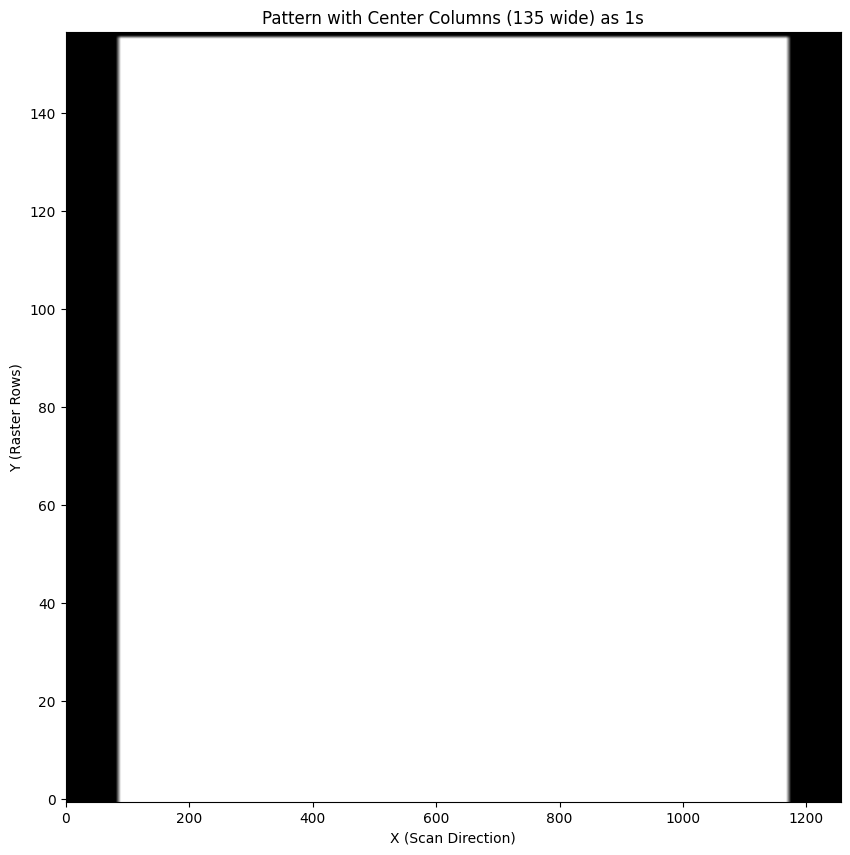

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# --- Settings for the pattern and display ---
sampling_rate = 20_000_000  # 100 MHz (Assuming 100MHz is 100,000,000, 20,000,000 is 20MHz)
line_duration_us = 157
# Calculate samples per line based on the sampling rate and line duration
# Note: 2_500_000 seems like a constant conversion factor, adjust if needed
samples_per_line = sampling_rate * line_duration_us // 2_500_000

# Width and height for the initial pattern matrix
height, width = 157, 157
pattern = np.zeros((height, width)) # Initialize pattern with all zeros

# --- New Logic: Set center columns to 1 ---
# Define how wide the center band of ones should be
# Adjust this value to make the center band wider or narrower
center_width_of_ones = 135

# Calculate the starting and ending column indices for the center band
# Integer division ensures we get whole numbers for indices
center_start_col = (width - center_width_of_ones) // 2
center_end_col = center_start_col + center_width_of_ones

# Set the values in the calculated center columns to 1.0
# The slicing `[:, ...]` means "all rows" for the specified columns
pattern[:, center_start_col:center_end_col] = 1.0

# --- Interpolation and Final Touches ---
# Interpolate each row to match the scan resolution (samples_per_line)
waveform_rows = []
for row in pattern:
    # Create an array of original indices from 0 to 1, matching the pattern's width
    original_indices = np.linspace(0, 1, width)
    # Create an array of target indices from 0 to 1, matching the desired samples_per_line
    target_indices = np.linspace(0, 1, samples_per_line)
    # Perform linear interpolation to stretch or shrink the row
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    waveform_rows.append(active_row)

# Set the last row to all zeros as specified in the original code
# This might be for specific display or hardware reasons
if waveform_rows: # Ensure waveform_rows is not empty before accessing last element
    waveform_rows[-1] = np.zeros(len(waveform_rows[-1]))

# --- Visualization ---
# Convert the list of arrays back into a NumPy array for imshow
waveform_rows_np = np.array(waveform_rows)

plt.figure(figsize=(10, 10))
# 'cmap='gray'' shows 0 as black and 1 as white
# 'aspect='auto'' allows the image to stretch to fit the figure
# 'origin='lower'' places the (0,0) index at the bottom-left, common for image data
plt.imshow(waveform_rows_np, cmap='gray', aspect='auto', origin='lower')
plt.title(f"Pattern with Center Columns ({center_width_of_ones} wide) as 1s")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False) # Turn off the grid for a cleaner image
plt.show()


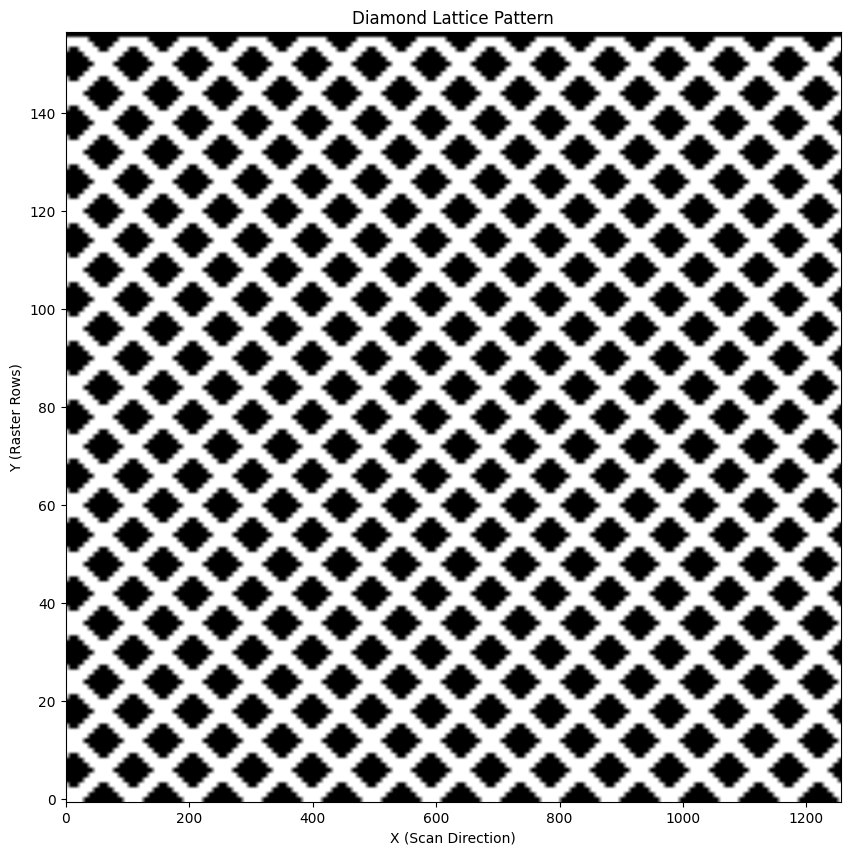

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Settings for printing
sampling_rate = 20_000_000  # 100 MHz
line_duration_us = 157
samples_per_line = sampling_rate * line_duration_us // 2_500_000

# Width and height for viewing purposes
height, width = 157, 157
pattern = np.zeros((height, width))

# Thicker lines — increase to make lines wider
line_spacing = 12
line_thickness = 4

# Generate diamond lattice pattern
for y in range(height):
    for x in range(width):
        if abs((x + y) % line_spacing) < line_thickness or abs((x - y) % line_spacing) < line_thickness:
            pattern[y, x] = 1.0

# Interpolate each row to match the scan resolution
waveform_rows = []
for row in pattern:
    original_indices = np.linspace(0, 1, width)
    target_indices = np.linspace(0, 1, samples_per_line)
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    waveform_rows.append(active_row)

waveform_rows[-1] = np.zeros(len(waveform_rows[-1]))

# Show the final pattern visually
plt.figure(figsize=(10, 10))
plt.imshow(waveform_rows, cmap='gray', aspect='auto', origin='lower')
plt.title("Diamond Lattice Pattern")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()

We need to do some sample redistribution in order to correct for the sinusoidal velocity of the mirror

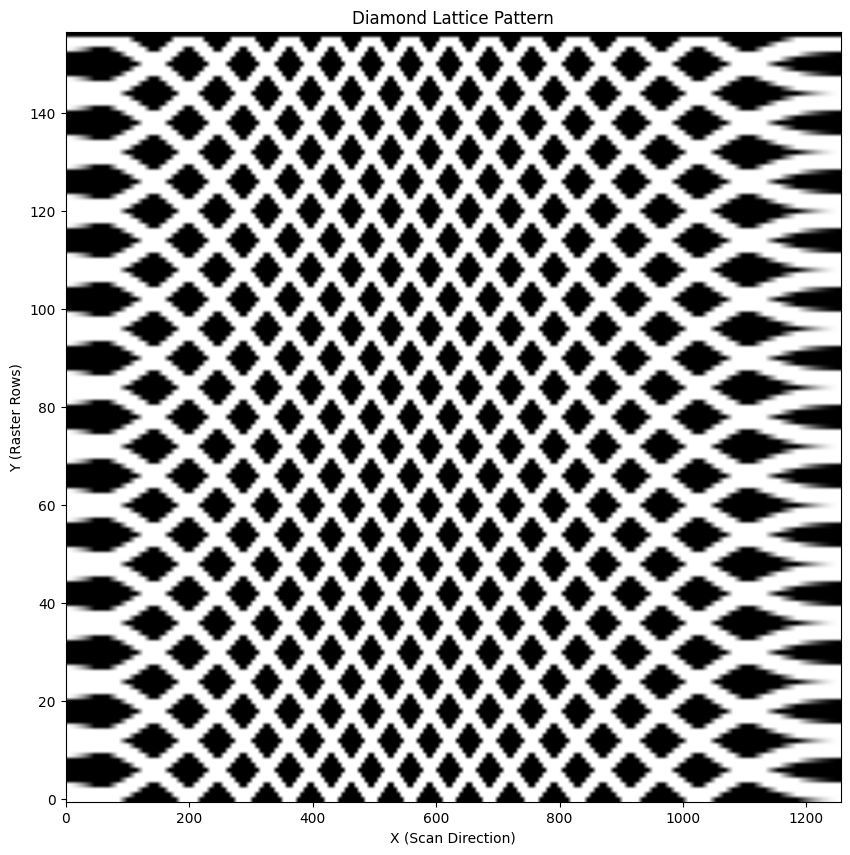

In [14]:
# Interpolate each row with sinusoidal-like sample redistribution
waveform_rows = []
original_indices = np.linspace(0, 1, width)

# Generate lookup table once — weight more samples to the edges
def generate_nonuniform_indices(n_samples):
    lin = np.linspace(0, 1, n_samples)
    # Weighting more at edges using sine shape (slower scan at edges)
    # This maps uniform time to nonlinear space
    return 0.5 - 0.5 * np.cos(np.pi * lin**0.9) # Smoothly distributes from 0 to 1

target_indices = generate_nonuniform_indices(samples_per_line)

for row in pattern:
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    waveform_rows.append(active_row)

waveform_rows[-1] = np.zeros(len(waveform_rows[-1]))
# Show the final pattern visually
plt.figure(figsize=(10, 10))
plt.imshow(waveform_rows, cmap='gray', aspect='auto', origin='lower')
plt.title("Diamond Lattice Pattern")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()

### Sequenced Output

`waveform_rows` is our working waveform

We will load each of these rows individually and create a sequence with them

In [15]:
import nifgen
import time

t0 = time.perf_counter()
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000
    t1 = time.perf_counter()

    waveform_handle_array = []
    loop_counts = []

    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)

    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)
    session.configure_arb_sequence(sequence_handle, 2, 0)
    t2 = time.perf_counter()

    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED
    t3 = time.perf_counter()

    print(f"Session initiation took {t1-t0:.4f} seconds")
    print(f"Waveform upload and sequence configuration took {t2 - t1:.4f} seconds")
    print(f"Trigger setup took {t3-t2:.4f} seconds")
    print(f"Total time to trigger: {t3-t0:.4f} seconds")

    session.initiate()
    session.wait_until_done(max_time=3)

Session initiation took 0.0148 seconds
Waveform upload and sequence configuration took 0.1125 seconds
Trigger setup took 0.0003 seconds
Total time to trigger: 0.1276 seconds


DriverError: -1074118637: Maximum time exceeded before the operation completed.

### Motion Control

Now we have our waveform generated. The next thing we need to do is prepare the motion control system for the print

In [ ]:
import sys
sys.path.append('../../nanostride')
import SPiiPlusPython as sp
import pipython
from pipython import GCSDevice

In [31]:
pidevice = pipython.GCS2Device("C-887")
pidevice.ConnectRS232(5, 115200)
axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
def zero_hexapod():
    for axis in axes:
        pidevice.MOV(axis, 0)
#zero_hexapod()

In [32]:
hc = sp.OpenCommSerial(1, 115200)
sp.EnableM(hc, [0, 1, -1], sp.SYNCHRONOUS, True)
sp.RunBuffer(hc, 1, "STARTUP", sp.SYNCHRONOUS, True)


Need a single axis to move back and forth for scanning

It should move at 7.91 mm/s

Going back and forth to make a 10mm strip, 10um tall

In [33]:
sp.DisableAll(hc)

In [34]:
sp.EnableM(hc, [0, 1, -1], sp.SYNCHRONOUS, True)

### Putting it all together

In [ ]:
import nifgen

stage_x = sp.GetTargetPosition(hc, 0, sp.SYNCHRONOUS)
stage_y = sp.GetTargetPosition(hc, 1, sp.SYNCHRONOUS)

axes = [0,1,-1]
sp.MultiPointM(
    hc,
    sp.MotionFlags.ACSC_AMF_VELOCITY,
    axes,
    1,
    failure_check=True
)

# Getting AWG ready
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000

    waveform_handle_array = []
    loop_counts = []

    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)

    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)
    session.configure_arb_sequence(sequence_handle, 2.2, 0)

    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED

    # Get starting position for hexapod and stage
    hexapod_axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
    hexapod_positions = pidevice.qPOS(hexapod_axes)
    hexapod_z = hexapod_positions['Z']

    # Loop for multipoint motion and lowering of hexapod
    layers = 10
    y_lims = 0.8
    z_steps = 0.001

    # MAY NEED TO THREAD THIS
    session.initiate()
    for i in range(layers):
        print(f"Starting layer {i+1}")
        sp.ExtAddPointM(hc, axes, (stage_x, stage_y + y_lims), 7.91)
        sp.WaitMotionEnd(hc, sp.Axis.ACSC_AXIS_1, timeout=-1)
        print(f"Moving down")
        pidevice.MOV('Z', (hexapod_z - ((i+1)*z_steps)))
        y_lims *= -1
    session.abort()
    sp.EndSequenceM(hc, axes) # end of multipoint motion
    #pidevice.CloseConnection()
    sp.DisableAll(hc)
    #sp.CloseComm(hc)


Starting layer 1
Moving down
Starting layer 2
Moving down
Starting layer 3
Moving down
Starting layer 4
Moving down
Starting layer 5
Moving down
Starting layer 6
Moving down
Starting layer 7
Moving down
Starting layer 8
Moving down
Starting layer 9
Moving down
Starting layer 10
Moving down


This was successful, but had some issues with timing.

In [35]:
import nifgen

stage_x = sp.GetTargetPosition(hc, 0, sp.SYNCHRONOUS)
stage_y = sp.GetTargetPosition(hc, 1, sp.SYNCHRONOUS)

axes = [0,1,-1]
sp.MultiPointM(
    hc,
    sp.MotionFlags.ACSC_AMF_VELOCITY,
    axes,
    1,
    failure_check=True
)

with nifgen.Session("Dev1") as session:

    # Set up AWG
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 20_000_000

    # Create data structures
    waveform_handle_array = []
    loop_counts = []
    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)
    session.configure_arb_sequence(sequence_handle, 1, 0)

    # Set up triggers
    session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode = nifgen.TriggerMode.STEPPED

    # Get starting position for hexapod
    hexapod_axes = ['X', 'Y', 'Z', 'U', 'V', 'W']
    hexapod_positions = pidevice.qPOS(hexapod_axes)
    hexapod_z = hexapod_positions['Z']

    # Print parameters
    layers = 10
    y_lims = 1.5
    z_steps = 0.001


    # Initiate -> Move Stage -> Abort -> Move Hexapod -> Initiate
    for i in range(layers):
        session.initiate()
        print(f"Starting layer {i+1}")
        sp.ExtAddPointM(hc, axes, (0, y_lims), 15.82)
        sp.WaitMotionEnd(hc, sp.Axis.ACSC_AXIS_1, timeout=-1)            
        session.abort()
        print(f"Moving down")
        pidevice.MOV('Z', (hexapod_z - ((i+1)*z_steps)))
        y_lims *= -1

set_zero()

sp.EndSequenceM(hc, axes) # end of multipoint motion
pidevice.CloseConnection()
sp.DisableAll(hc)
sp.CloseComm(hc)


Starting layer 1
Moving down
Starting layer 2
Moving down
Starting layer 3
Moving down
Starting layer 4
Moving down
Starting layer 5
Moving down
Starting layer 6
Moving down
Starting layer 7
Moving down
Starting layer 8
Moving down
Starting layer 9
Moving down
Starting layer 10
Moving down


In [ ]:
with nifgen.Session("Dev1") as end_session:
    end_session.start_trigger_type = nifgen.StartTriggerType.DIGITAL_EDGE
    end_session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    end_session.digital_edge_start_trigger_edge = nifgen.StartTriggerDigitalEdgeEdge.RISING
    end_session.trigger_mode = nifgen.TriggerMode.CONTINUOUS
    end_session.arb_sample_rate = 20_000_000
    end_session.arb_gain = 1

    end_session.output_mode = nifgen.OutputMode.ARB
    end = end_session._create_waveform_f64_numpy(np.ones(16).astype(np.float64))
    end_session.configure_arb_waveform(end,2,0)
    end_session.initiate()
    time.sleep(3)
    #end_session.abort()

In [ ]:
import nifgen
import time

def set_zero():
    with nifgen.Session("Dev1") as session:
        session.output_mode = nifgen.OutputMode.FUNC
        session.configure_standard_waveform(waveform=nifgen.Waveform.DC, amplitude=0, frequency=1, dc_offset=0, start_phase=0.0)
        with session.initiate():
            time.sleep(0.1)

In [ ]:
import nifgen
import time

with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.FUNC
    session.configure_standard_waveform(waveform=nifgen.Waveform.DC, amplitude=0, frequency=1, dc_offset=-0.12, start_phase=0.0)
    with session.initiate():
        time.sleep(5)

In [ ]:
pidevice.CloseConnection()
sp.DisableAll(hc)
sp.CloseComm(hc)